In [1]:
%matplotlib inline

import torch
import matplotlib.pyplot as plt
import numpy as np

from utils import visualize_optimizer
from checker import test_optimizer

# Laboratorium 8. Optymalizatory

Notebook jest luźno wzorowany na [przeglądzie Sebastiana Rudera](https://ruder.io/optimizing-gradient-descent/index.html).

Państwa dzisiejszym zadaniem będzie zaimplementowanie najpopularniejszych optymalizatorów stosowanych w uczeniu maszynowym.

Każda z implementowanych przez Państwa klas dziedziczy po klasie `Optimizer`, w której gotowe są już pewne funkcjonalności. Państwa zadanie to przeładowanie metody `step` (oraz naturalnie dodawanie wymaganych rzeczy do konstruktora).

Ogólne uwagi do zadań:
* Proszę zwracać uwagę przy zmienianiu parametrów z średku optimizera, tak aby faktycznie je zmieniać, *hint*: `tensor.data` oraz patrz poniższa impelemtacja `GradientDescent`.
* Kolejność wzorów w sekcjach "Update" kolejnych metod jest jednocześnie zalecaną kolejnością implementacji.



In [2]:
from typing import List

class Optimizer:
    """Base class for each optimizer"""
    
    def __init__(self, initial_params: List[torch.tensor]):
        # store model weights
        self.params = initial_params
    
    def step(self):
        """Updates the weights stored in self.params"""
        raise NotImplementedError()
         
    def zero_grad(self):
        """Torch accumulates gradients, so we need to clear them after every update"""
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

                
class GradientDescent(Optimizer):
    
    def __init__(self, initial_params: List[torch.tensor], learning_rate):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
    
    def step(self):
        for param in self.params:
            # actually change the values in the param
            param.data = param.data - self.learning_rate * param.grad

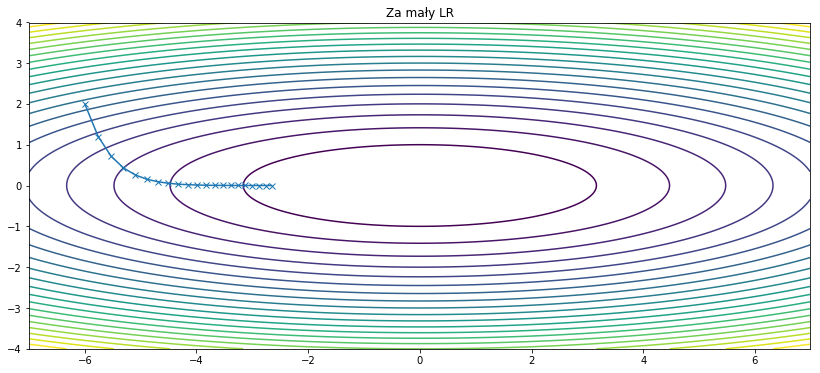

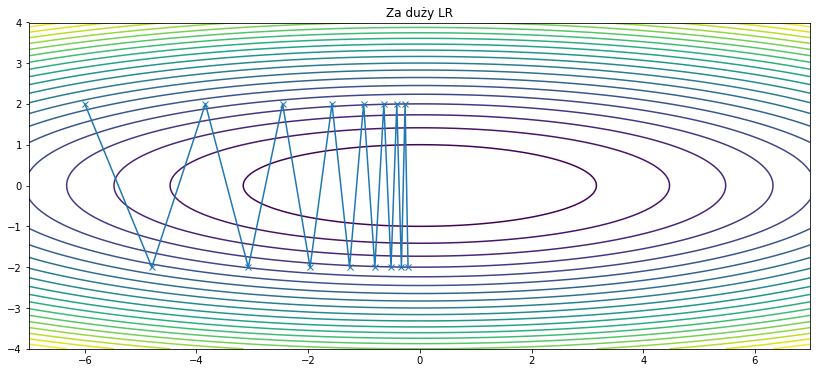

In [3]:
visualize_optimizer(GradientDescent, n_steps=20, learning_rate=0.1, title='Za mały LR')
visualize_optimizer(GradientDescent, n_steps=15, learning_rate=0.5, title='Za duży LR')

## Momentum (1 pkt.)
Hiperparamerty:
* $\eta$ - Learning Rate (typowe wartości: od 0.001 do 0.01)
* $\gamma$ - Momentum (zawsze < 1, typowo 0.9)

### Update
Zmiany dokonywane są na podstawie wektora "pędu" (ang. *momentum*) $\Delta$, który rośnie jeżeli dokonujemy zmian w tym samym kierunku.

<font size="+2"> $$ \Delta_{t+1} = \gamma  \Delta_{t} + \eta \nabla_\theta \mathcal{L}(\theta_t) $$ </font><br>
<font size="+2"> $$ \theta_{t+1} = \theta_{t} - \Delta_{t+1} $$ </font>

#### Uwagi
* $\Delta_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.

In [4]:
class Momentum(Optimizer):
    
    def __init__(self, initial_params, learning_rate, gamma):
        super().__init__(initial_params)
        
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.old_v = [torch.zeros(params.shape) for params in initial_params]
    
    def step(self):
        new_v = self.old_v
        for i, param in enumerate(self.params):
            new_v[i] = self.gamma * self.old_v[i] + self.learning_rate * param.grad
            self.old_v[i] = new_v[i]
            param.data = param.data - new_v[i]

In [5]:
test_optimizer(Momentum)

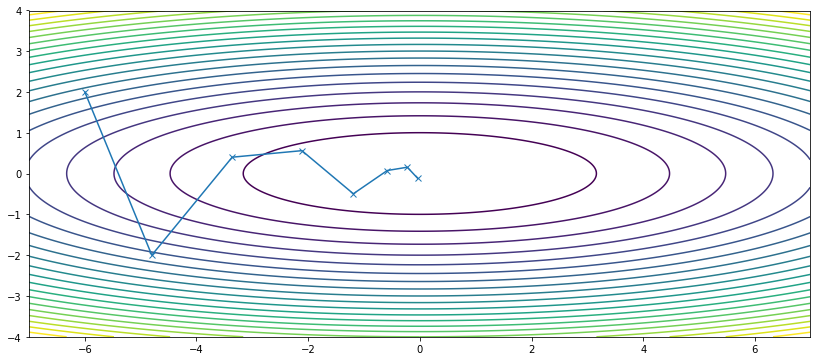

In [6]:
visualize_optimizer(Momentum, n_steps=7, learning_rate=0.5, gamma=0.4)

## Adagrad  (1 pkt.)
Hiperparamerty:
* $\eta$ - Learning Rate (typowe wartości: od 0.001 do 0.01)
* $\epsilon$ - Dodawany do mianownika w celu uniknięcia dzielenia przez 0 (typowo $10^{-8}$)

### Update
W każdym korku adaptujemy stałą uczenia $\eta$ dla każdego z wymiarów wag na podstawie sumy kwadratów dotychczasowych gradientów.

<font size="+2"> $$ \displaystyle  G_t = \sum_{i = 1}^{t} \big(\nabla_\theta \mathcal{L}(\theta_i)\big)^2 $$ </font>

<font size="+2"> $$ \theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{G_t + \epsilon}} \odot \nabla_\theta \mathcal{L}(\theta_t) $$ </font>



<font size="+0"> gdzie $G_t$ to suma kwadratów gradientów $\nabla_\theta \mathcal{L}(\theta_i)^2$ dla kroków $i = 1, .., t$ </font>

##### Uwagi
* $G_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.
* $\odot$ to mnożenie *element-wise*.
* podnoszenie gradientu do kwadratu jest robione *element-wise*.

In [7]:
class Adagrad(Optimizer):
    
    def __init__(self, initial_params, learning_rate, epsilon):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.sq_grad_sum = [torch.zeros(params.shape) for params in initial_params]
        
    def step(self):
        for i, param in enumerate(self.params):
            self.sq_grad_sum[i] += param.grad ** 2
            param.data = param.data - (self.learning_rate / torch.sqrt(self.sq_grad_sum[i] + self.epsilon)) * param.grad

In [8]:
test_optimizer(Adagrad)

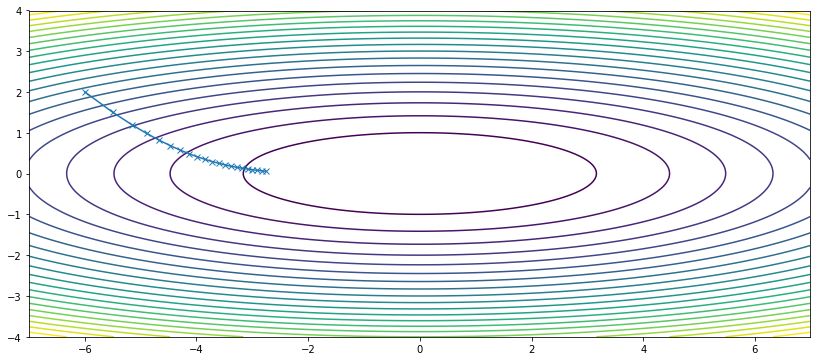

In [9]:
visualize_optimizer(Adagrad, n_steps=20, learning_rate=0.5, epsilon=1e-8)

## RMSProp  (1 pkt.)
Hiperparametry:
* $\eta$ - Learning Rate (typowe wartości: od 0.001 do 0.01)
* $\gamma$ - Współczynnik średniej kroczącej (typowo 0.9)
* $\epsilon$ - Dodawany do mianownika w celu uniknięcia dzielenia przez 0 (typowo $10^{-8}$)

### Update
Analogicznie dla algorytmu *Adagrad* adaptujemy stałą uczenia, lecz tym razem zamiast sumy, robimy to średnią kroczącą ze współczynnikiem $\gamma$.

<font size="+2"> $$ H_{t+1} = \gamma H_{t} + (1 - \gamma) \big( \nabla_\theta \mathcal{L}(\theta_t)\big)^2 $$ </font>

<font size="+2"> $$ \theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{H_{t+1} + \epsilon}} \odot \nabla_\theta \mathcal{L}(\theta_t) $$ </font>



gdzie $H_t$ to średnia krocząca kwadratów gradientów $(\nabla_\theta \mathcal{L}(\theta_t))^2$ z kroków $0, 1, ..., t$ ze współczynnikiem $\gamma$.

#### Uwagi
* $H_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.
* $\odot$ to mnożenie *element-wise*.
* podnoszenie gradientu do kwadratu jest robione *element-wise*.

In [10]:
class RMSProp(Optimizer):
    
    def __init__(self, initial_params, learning_rate, gamma, epsilon):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.sq_grad_sum = [torch.zeros(params.shape) for params in initial_params]
        
    def step(self):
        for i, param in enumerate(self.params):
            self.sq_grad_sum[i] = self.gamma * self.sq_grad_sum[i] + (1 - self.gamma) * param.grad ** 2
            param.data = param.data - (self.learning_rate / torch.sqrt(self.sq_grad_sum[i] + self.epsilon)) * param.grad

In [11]:
test_optimizer(RMSProp)

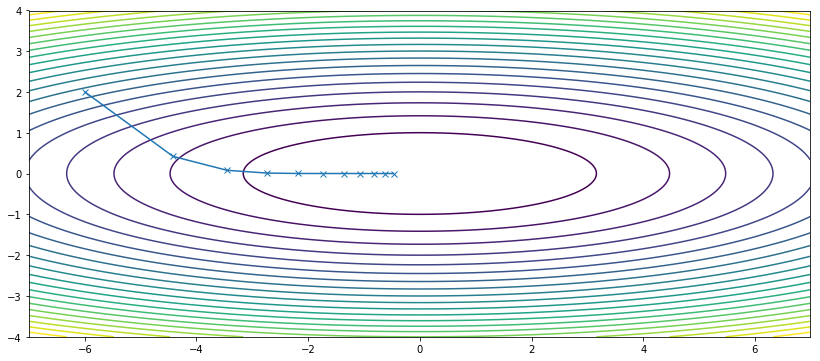

In [12]:
visualize_optimizer(RMSProp, n_steps=10, learning_rate=0.5, gamma=0.9, epsilon=1e-8)

## Adadelta  (2 pkt.)
Hiperparametry:
* $\gamma$ - Współczynnik średniej kroczącej (typowo 0.9)
* $\epsilon$ - Dodawany do mianownika w celu uniknięcia dzielenia przez 0 oraz rozpoczęcia uczenia (typowo $10^{-8}$ do $10^{-2}$)

### Update
Eliminujemy stałą uczenia $\eta$ i sprawiamy, że "prędkość" poprawek jest podobna do faktycznych poprawek uzależniając krok uczenia od średniej kroczącej poprzednich poprawek.

<font size="+2"> $$ H_{t+1} = \gamma H_{t} + (1 - \gamma) \big( \nabla_\theta \mathcal{L}(\theta_t)\big)^2 $$ </font>

<font size="+2"> $$ \Delta_{t+1} = \frac{\sqrt{D_{t} + \epsilon}}{\sqrt{H_{t+1} + \epsilon}} \odot \nabla_\theta \mathcal{L}(\theta_t) $$ </font>

<font size="+2"> $$ \theta_{t+1} = \theta_t - \Delta_{t+1} $$ </font>

<font size="+2"> $$ D_{t+1} = \gamma D_{t} + (1 - \gamma) \Delta_{t+1}^2 $$ </font>

#### Uwagi:
* $H_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.
* $D_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.
* $\odot$ to mnożenie *element-wise*.
* podnoszenie gradientu do kwadratu jest robione *element-wise*.

In [13]:
class Adadelta(Optimizer):
    def __init__(self, initial_params, gamma, epsilon):
        super().__init__(initial_params)
        self.gamma = gamma
        self.epsilon = epsilon
        self.H = [torch.zeros(params.shape) for params in initial_params]
        self.old_D = [torch.zeros(params.shape) for params in initial_params]
        
    def step(self):
        for i, param in enumerate(self.params):
            self.H[i] = self.gamma * self.H[i] + (1 - self.gamma) * param.grad ** 2
            delta = (torch.sqrt(self.old_D[i] + self.epsilon) / torch.sqrt(self.H[i] + self.epsilon)) * param.grad
            param.data = param.data - delta
            self.old_D[i] = self.gamma * self.old_D[i] + (1 - self.gamma) * delta ** 2


In [14]:
test_optimizer(Adadelta)

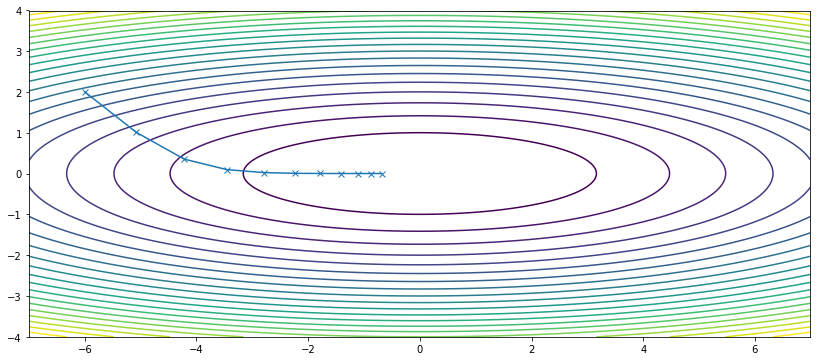

In [15]:
visualize_optimizer(Adadelta, n_steps=10, gamma=0.9, epsilon=1e-1)

## Adam (2 pkt.)

Hiperparametry:
* $\eta$ - Learning Rate (typowo 0.001)
* $\beta_1$ - współczynnik średniej kroczącej pierwszego momentu (typowo 0.9)
* $\beta_2$ - współczynnik średniej kroczącej drugiego momentu (typowo 0.999)
* $\epsilon$ - zapobiega dzieleniu przez zero (typowo $10^{-8}$)

### Update
Adaptujemy gradient dwiema średnimi kroczącymi, pierwszego $m$ i drugiego $v$ momentu. Na początku uczenia te średnie są bardzo zbiasowane do 0, stąd wprowadzane są poprawka $\hat{m}$ i $\hat{v}$, im dalej w procesie uczenia, tym te poprawki wprowadzają mniejsze zmiany.  

<font size="+2"> $$ m_{t+1} = \beta_1 m_{t} + (1 - \beta_1)  \nabla_\theta \mathcal{L}(\theta_t) $$ </font>
<font size="+2"> $$ v_{t+1} = \beta_2 v_{t} + (1 - \beta_2)  \big( \nabla_\theta \mathcal{L}(\theta_t) \big)^2 $$ </font>
<br>
<font size="+2"> $$  \hat{m} = \frac{m_{t+1}}{1 - \beta_1^{(t+1)}} $$ </font><br>
<font size="+2"> $$  \hat{v} = \frac{v_{t+1}}{1 - \beta_2^{(t+1)}} $$ </font>
<br>
<font size="+2"> $$ \theta_{t+1} = \theta_t - \eta \frac{\hat{m}}{\sqrt{\hat{v}} + \epsilon} $$ </font>

#### Uwagi
* $m_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.
* $v_0 = \mathbf{0}$, wymiar taki sam jak $\theta$. 
* $\beta_1^{(t+1)}$ oraz $\beta_2^{(t+1)}$ to potęgowania.
* podnoszenie gradientu do kwadratu jest robione *element-wise*.


In [16]:
class Adam(Optimizer):
   
    def __init__(self, initial_params, learning_rate, beta1, beta2, epsilon):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = [torch.zeros(param.shape) for param in initial_params]
        self.v = [torch.zeros(param.shape) for param in initial_params]
        self.t = 1
        
    def step(self,):
        for i, param in enumerate(self.params):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * param.grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * param.grad ** 2
            m_dash = self.m[i] / (1 - self.beta1 ** self.t)
            v_dash = self.v[i] / (1 - self.beta2 ** self.t)
            param.data = param.data - self.learning_rate * m_dash / (torch.sqrt(v_dash) + self.epsilon)
        self.t += 1

In [17]:
test_optimizer(Adam)

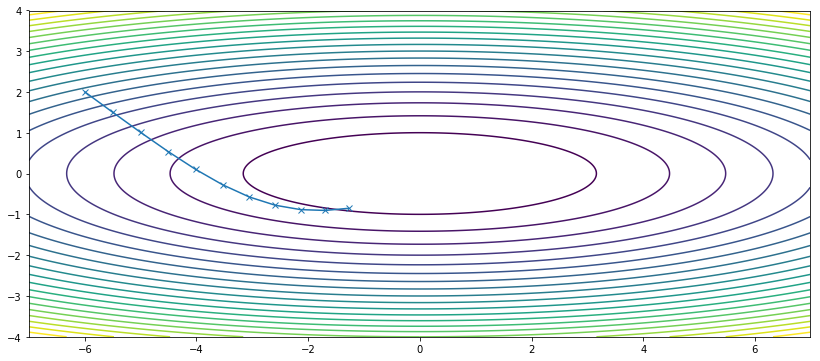

In [18]:
visualize_optimizer(Adam, n_steps=10, learning_rate=0.5, beta1=0.9, beta2=0.999, epsilon=1e-8)